# Feature engineering
------------------------------

This example shows how to use automated feature generation to improve your model's performance.

The data used is a variation on the Australian weather dataset from [https://www.kaggle.com/jsphyg/weather-dataset-rattle-package](https://www.kaggle.com/jsphyg/weather-dataset-rattle-package). The goal of this dataset is to predict whether or not it will rain tomorrow training a binay classifier on target `RainTomorrow`.

## Load the data

In [1]:
# Import packages
import pandas as pd
from atom import ATOMClassifier

In [2]:
# Load data
X = pd.read_csv('./datasets/weatherAUS.csv')

# Let's have a look at a subset of the data
X.sample(frac=1).iloc[:5, :8]

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed
83378,Brisbane,11.6,22.1,5.0,0.4,10.0,W,33.0
27204,Richmond,22.6,22.6,0.0,18.1,NaN,SSW,20.0
132851,Launceston,5.6,16.7,0.0,NaN,NaN,SE,30.0
59603,Bendigo,22.6,41.6,0.0,NaN,NaN,N,74.0
94683,Adelaide,11.2,19.5,0.2,3.8,11.2,SW,37.0


## Run the pipeline

In [3]:
# Initiate ATOM and apply data cleaning
atom = ATOMClassifier(X, n_rows=1e4, test_size=0.2, verbose=0, random_state=1)
atom.impute(strat_num='knn', strat_cat='remove', min_frac_rows=0.8)
atom.encode(max_onehot=10, frac_to_other=0.04)

# Let's see how a LightGBM model performs without adding additional features
atom.run('LGB', metric='auc')
atom.scoring()

Results ===================== >>
LightGBM --> roc_auc: 0.875


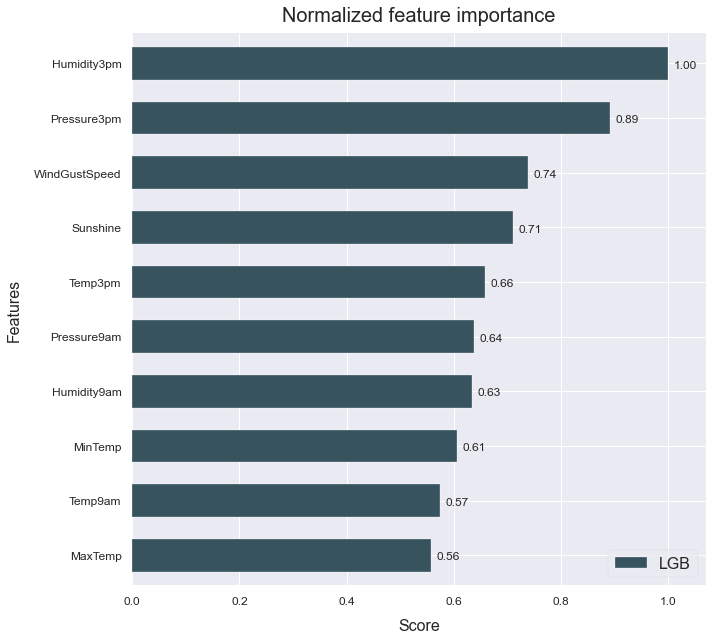

In [4]:
# What are the most important fetaures?
atom.plot_feature_importance(show=10)

**Now let's create some new fetaures using Deep Feature Synthesis**

In [5]:
atom.verbose = 2  # Increase verbosity to see the output

# Create 100 new features using DFS
atom.feature_generation(strategy='dfs', n_features=100, operators=['add', 'sub', 'log', 'sqrt'])

Fitting FeatureGenerator...
Creating new features...
 --> 100 new features were added to the dataset.


C:\Users\Mavs\AppData\Roaming\Python\Python37\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Mavs\AppData\Roaming\Python\Python37\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [6]:
# The warnings warn us that some operators created missing values!
# We can see the columns with missing values using the missing attribute
atom.missing

LOG(RainToday_other)    8873
SQRT(MinTemp)            146
dtype: int64

In [7]:
# We can use the impute method again
atom.impute(strat_num='knn', strat_cat='remove', min_frac_rows=0.8)

Fitting Imputer...
Imputing missing values...
 --> Dropping feature LOG(RainToday_other) for containing 8873 (99%) missing values.
 --> Imputing 146 missing values using the KNN imputer in feature SQRT(MinTemp).


In [8]:
# 100 new features may be to much...
# Let's check for multicollinearity and use RFECV to reduce the number even further
atom.feature_selection(strategy='RFECV', solver='lgb', n_features=30, scoring='auc', max_correlation=0.98)

Fitting FeatureSelector...
Performing feature selection ...
 --> Feature Cloud3pm + RainToday_No was removed due to collinearity with another feature.
 --> Feature Cloud3pm + RainToday_Yes was removed due to collinearity with another feature.
 --> Feature Cloud3pm + RainToday_other was removed due to collinearity with another feature.
 --> Feature Cloud3pm + WindDir3pm was removed due to collinearity with another feature.
 --> Feature Cloud3pm + WindDir9am was removed due to collinearity with another feature.
 --> Feature Cloud3pm + WindGustDir was removed due to collinearity with another feature.
 --> Feature Cloud3pm - RainToday_No was removed due to collinearity with another feature.
 --> Feature Cloud3pm - WindDir9am was removed due to collinearity with another feature.
 --> Feature Cloud9am + Humidity3pm was removed due to collinearity with another feature.
 --> Feature Evaporation + Humidity3pm was removed due to collinearity with another feature.
 --> Feature Evaporation - Locat

In [9]:
# The collinear attribute shows what features were removed due to multicollinearity
atom.collinear

,drop_feature,correlated_feature,correlation_value
0,Cloud3pm + RainToday_No,Cloud3pm + Location,0.98122
1,Cloud3pm + RainToday_Yes,Cloud3pm + Location,0.98433
2,Cloud3pm + RainToday_other,"Cloud3pm + Location, Cloud3pm + RainToday_Yes","0.99941, 0.9835"
3,Cloud3pm + WindDir3pm,"Cloud3pm + Location, Cloud3pm + RainToday_No, ...","0.99975, 0.98093, 0.98414, 0.99917"
4,Cloud3pm + WindDir9am,"Cloud3pm + Location, Cloud3pm + RainToday_No, ...","0.99968, 0.98054, 0.98435, 0.9991, 0.99962"
5,Cloud3pm + WindGustDir,"Cloud3pm + Location, Cloud3pm + RainToday_No, ...","0.99976, 0.98066, 0.98437, 0.99918, 0.99976, 0..."
6,Cloud3pm - RainToday_No,"Cloud3pm + Location, Cloud3pm + RainToday_Yes,...","0.98405, 0.99947, 0.98433, 0.98386, 0.98408, 0..."
7,Cloud3pm - WindDir9am,"Cloud3pm + Location, Cloud3pm + RainToday_No, ...","0.99968, 0.98128, 0.98368, 0.99908, 0.99925, 0..."
8,Cloud9am + Humidity3pm,Cloud3pm + Humidity3pm,0.99513
9,Evaporation + Humidity3pm,"Cloud3pm + Humidity3pm, Cloud9am + Humidity3pm...","0.98248, 0.98147, -0.98196"


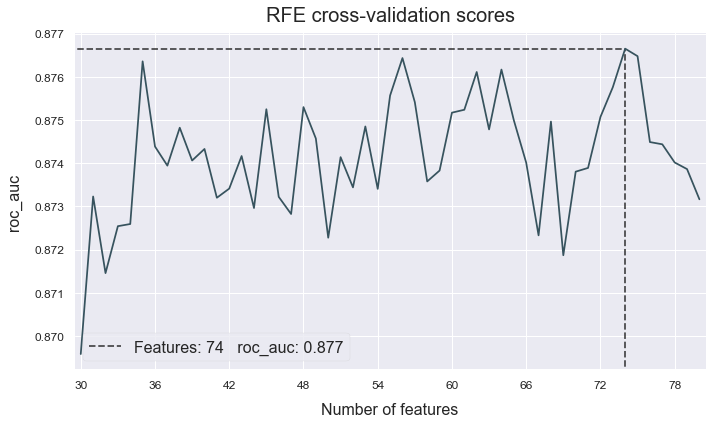

In [10]:
# After applying RFECV, we can plot the score per number of features
atom.plot_rfecv()

In [11]:
# Let's see how the model performs now
atom.run('LGB')


Running pipeline ============================= >>
Models in pipeline: LGB
Metric: roc_auc


Results for LightGBM:         
Fitting -----------------------------------------
Score on the train set --> roc_auc: 0.9974
Score on the test set  --> roc_auc: 0.8736
Time elapsed: 1.183s
-------------------------------------------------
Total time: 1.213s


Final results ========================= >>
Duration: 1.213s
------------------------------------------
LightGBM --> roc_auc: 0.874


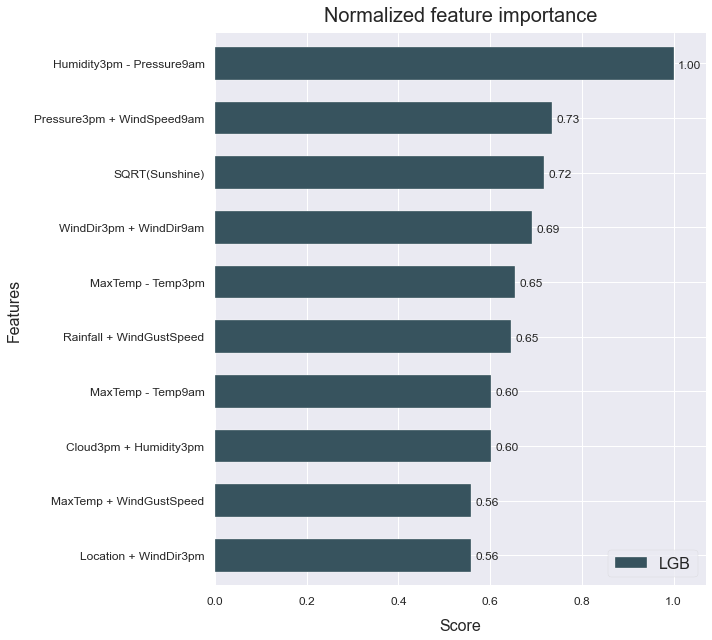

In [12]:
# Did the feature importance change?
atom.plot_feature_importance(show=10)

**Lets try the same using Genetic Feature Generation**

In [13]:
atom = ATOMClassifier(X, n_rows=1e4, test_size=0.2, verbose=0, random_state=1)
atom.impute(strat_num='knn', strat_cat='remove', min_frac_rows=0.8)
atom.encode(max_onehot=10, frac_to_other=0.04)

# Change verbosity to print extended info
atom.verbose = 2

# Create new features using Genetic Programming
atom.feature_generation(strategy='genetic', n_features=20, generations=10, population=2000)

Fitting FeatureGenerator...
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0     3.17         0.127531        3          0.50405              N/A      9.96s
   1     3.10         0.338627        5         0.536586              N/A      9.43s
   2     3.50         0.443734        9         0.541692              N/A      8.39s
   3     4.44          0.47684        7          0.54494              N/A      6.50s
   4     6.25         0.512037       13         0.546193              N/A      5.60s
   5     7.47         0.507736        9         0.550266              N/A      4.48s
   6     7.73         0.500405       11          0.55324              N/A      3.54s
   7     7.99         0.497944       11         0.553398              N/A      2.33s
   8     9.29         0.494223       13        

In [14]:
# We can see the feature's fitness and description through the genetic_features attribute
atom.genetic_features

,name,description,fitness
0,Feature 24,"mul(sub(sub(sub(Humidity3pm, Sunshine), Sunshi...",0.542398
1,Feature 25,"mul(sub(sub(Humidity3pm, Sunshine), Sunshine),...",0.542240
2,Feature 26,"mul(sub(Humidity3pm, Sunshine), mul(sub(sub(Hu...",0.542240
3,Feature 27,"mul(mul(sub(sub(Humidity3pm, Sunshine), Sunshi...",0.542240
4,Feature 28,"mul(mul(sub(Humidity3pm, Sunshine), WindGustSp...",0.542240


In [15]:
# And fit the model again
atom.run('LGB', metric='auc')


Running pipeline ============================= >>
Models in pipeline: LGB
Metric: roc_auc


Results for LightGBM:         
Fitting -----------------------------------------
Score on the train set --> roc_auc: 0.9890
Score on the test set  --> roc_auc: 0.8788
Time elapsed: 0.460s
-------------------------------------------------
Total time: 0.470s


Final results ========================= >>
Duration: 0.472s
------------------------------------------
LightGBM --> roc_auc: 0.879


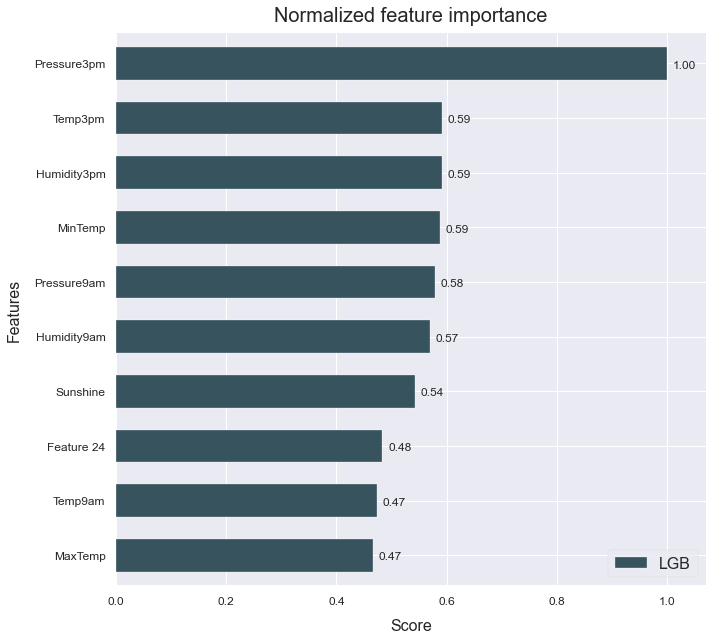

In [16]:
atom.plot_feature_importance(show=10)